# 1. Goodbooks-10k 
- Link : https://www.kaggle.com/zygmunt/goodbooks-10k

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pwd

'/content/drive/MyDrive/추천시스템/t 아카데미'

In [ ]:
%cd '/content/drive/MyDrive/추천시스템/t 아카데미'

/content/drive/MyDrive/추천시스템/t 아카데미


In [ ]:
import pandas as pd
import numpy as np
import plotnine 
from plotnine import *
import os, sys, gc
from tqdm.notebook import tqdm

In [ ]:
# 경로의 경우 각자의 환경에 맞게 설정해주면 됩니다. 
path = '/content/drive/MyDrive/추천시스템/t 아카데미/data/'

- books.csv : 책의 메타정보 
- book_tags.csv : 책-테그의 매핑정보 
- ratings.csv : 사용자가 책에 대해 점수를 준 평점정보 
- tags.csv : 테그의 정보 
- to_read.csv : 사용자가 읽으려고 기록해둔 책 (장바구니) 

In [ ]:
books = pd.read_csv(path + "books.csv")
book_tags = pd.read_csv(path + "book_tags.csv")
ratings = pd.read_csv(path + "ratings.csv")
tags = pd.read_csv(path + "tags.csv")
to_read = pd.read_csv(path + "to_read.csv")

## books의 메타정보 확인 

In [ ]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
books.columns

Index(['id', 'book_id', 'best_book_id', 'work_id', 'books_count', 'isbn',
       'isbn13', 'authors', 'original_publication_year', 'original_title',
       'title', 'language_code', 'average_rating', 'ratings_count',
       'work_ratings_count', 'work_text_reviews_count', 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5', 'image_url',
       'small_image_url'],
      dtype='object')

In [ ]:
books['small_image_url'].values[0]

'https://images.gr-assets.com/books/1447303603s/2767052.jpg'

<img src="https://github.com/choco9966/Recommendation-Tutorial/blob/master/05.%20%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%20%EC%8B%A4%EC%8A%B5%ED%95%98%EA%B8%B0/figure/figure02.png?raw=true" width="256" height="256" alt="그림 설명" />

- 책같은 경우에는 표지의 영향을 많이 받아서, 해당 이미지의 표지에서 특징을 추출해서 CNN 같은 모델로 유사한 책을 찾는 Contents Based Recommendation도 가능

In [ ]:
# 필요한 변수들만 사용 
books = books[['book_id', 'authors', 'title', 'ratings_count', 'average_rating', 'language_code']].reset_index(drop=True)

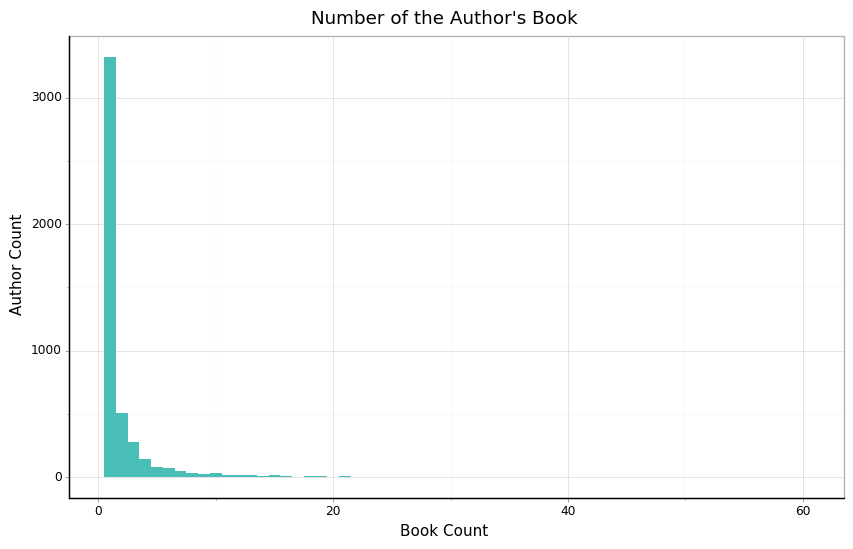

<ggplot: (8794925414641)>

In [ ]:
agg = books.groupby('authors')['authors'].agg({'count'})
# plotnine
## R : ggplot -> python : Plotnine
(ggplot(data = agg)
  + geom_histogram(aes(x='count'), binwidth = 1, fill = '#49beb7')
  + labs(title = "Number of the Author's Book",
         x = 'Book Count',
         y = 'Author Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
print("책의 숫자:", books['book_id'].nunique())
print("저자의 숫자:", books['authors'].nunique(), "\n")
print(pd.DataFrame(agg['count'].describe()).T)

책의 숫자: 10000
저자의 숫자: 4664 

        count      mean       std  min  25%  50%  75%   max
count  4664.0  2.144082  3.414442  1.0  1.0  1.0  2.0  60.0


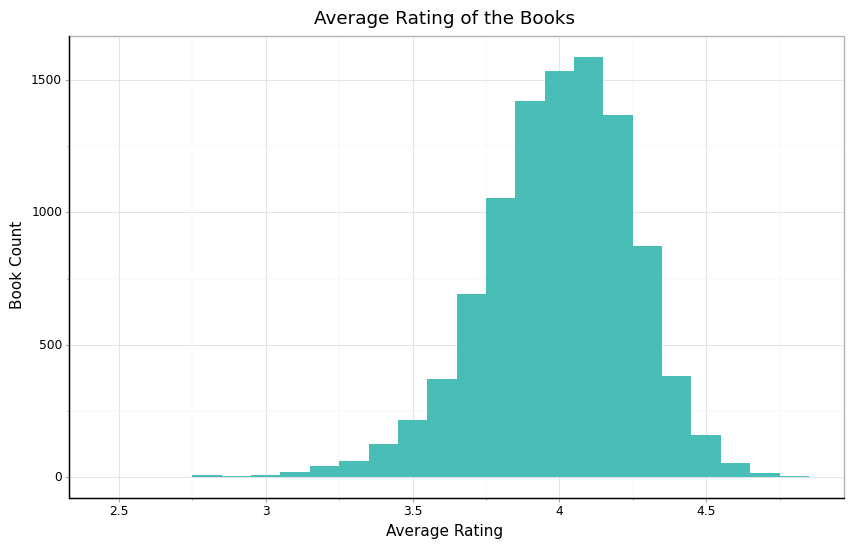

<ggplot: (8794925431821)>

In [ ]:
(ggplot(data = books)
  + geom_histogram(aes(x='average_rating'), binwidth = 0.1, fill = '#49beb7')
  + labs(title = "Average Rating of the Books",
         x = 'Average Rating',
         y = 'Book Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
books[books['average_rating'] <= 3].shape[0]

14

In [ ]:
books.sort_values(by='average_rating', ascending=False).head()

,book_id,authors,title,ratings_count,average_rating,language_code
3627,24812,Bill Watterson,The Complete Calvin and Hobbes,28900,4.82,eng
3274,8,"J.K. Rowling, Mary GrandPré","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",33220,4.77,eng
861,17332218,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",73572,4.77,eng
8853,95602,Francine Rivers,Mark of the Lion Trilogy,9081,4.76,en-US
7946,5031805,"Anonymous, Lane T. Dennis, Wayne A. Grudem",ESV Study Bible,8953,4.76,eng


- 3점이하의 평점이 낮은 책들은 유사도가 높더라도 추천을 안하는게 좋을 수 있음
- 평점이 높은 책들은 우선적으로 추천해주는게 좋음 
    하지만, 평점이 높더라도 사람들이 많이 보지않은 책일 수도 있음 

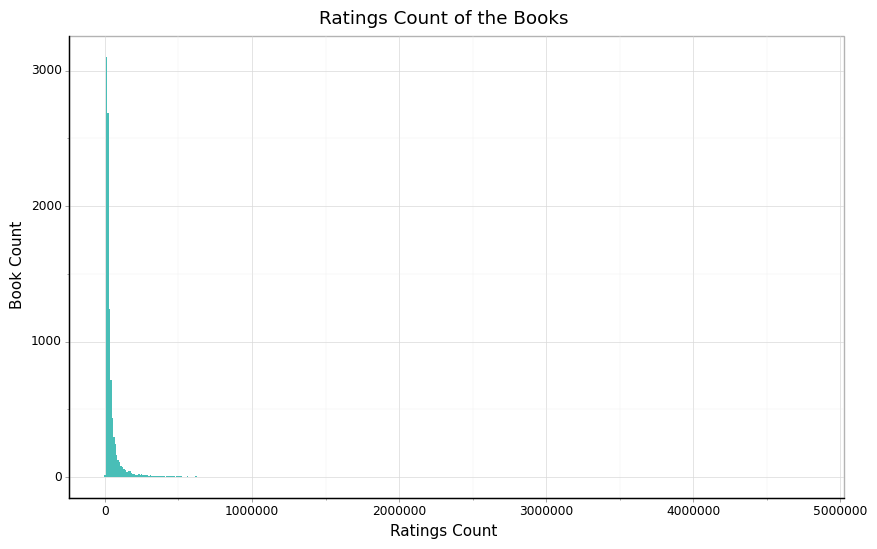

<ggplot: (8794925441785)>

In [ ]:
(ggplot(data = books)
  + geom_histogram(aes(x='ratings_count'), binwidth = 10000, fill = '#49beb7')
  + labs(title = "Ratings Count of the Books",
         x = 'Ratings Count',
         y = 'Book Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
pd.DataFrame(books['ratings_count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
ratings_count,10000.0,54001.2351,157369.956436,2716.0,13568.75,21155.5,41053.5,4780653.0


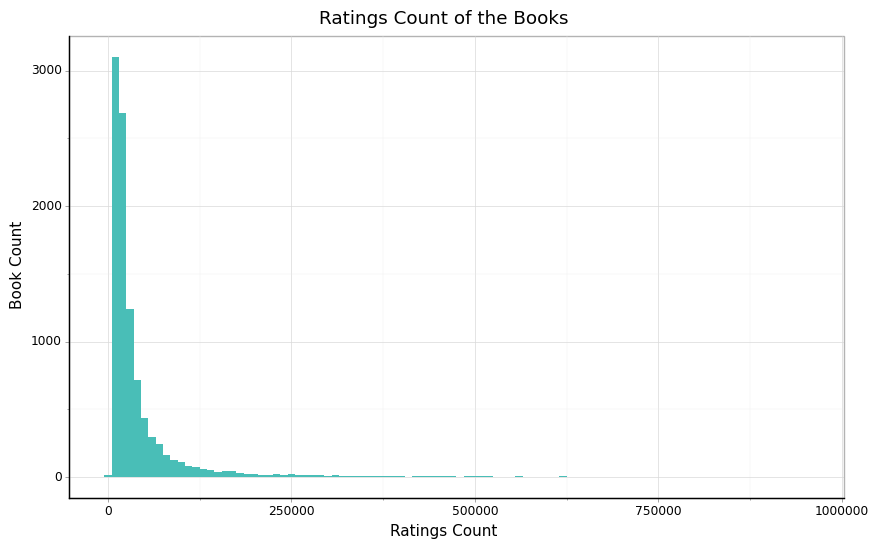

<ggplot: (8794925441617)>

In [ ]:
(ggplot(data = books[books['ratings_count'] < 1000000])
  + geom_histogram(aes(x='ratings_count'), binwidth = 10000, fill = '#49beb7')
  + labs(title = "Ratings Count of the Books",
         x = 'Ratings Count',
         y = 'Book Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
books.sort_values(by='ratings_count', ascending=False).head()

,book_id,authors,title,ratings_count,average_rating,language_code
0,2767052,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)",4780653,4.34,eng
1,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4602479,4.44,eng
2,41865,Stephenie Meyer,"Twilight (Twilight, #1)",3866839,3.57,en-US
3,2657,Harper Lee,To Kill a Mockingbird,3198671,4.25,eng
4,4671,F. Scott Fitzgerald,The Great Gatsby,2683664,3.89,eng


- Twilight (Twilight, #1)은 ratings_count는 높지만, average_rating은 낮은 편 

In [ ]:
agg = pd.DataFrame(books['language_code'].value_counts()).reset_index()
agg.columns = ['language_code', 'count']

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


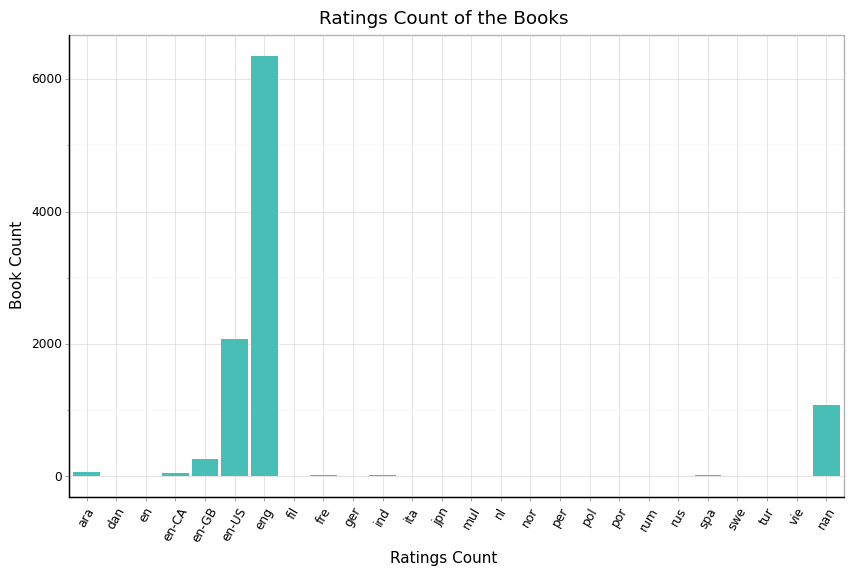

<ggplot: (8794914926953)>

In [ ]:
(ggplot(data = books)
  + geom_bar(aes(x='language_code'), fill = '#49beb7')
  + labs(title = "Ratings Count of the Books",
         x = 'Ratings Count',
         y = 'Book Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black', rotation=60),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
books['language_code'].unique()

array(['eng', 'en-US', 'en-CA', nan, 'spa', 'en-GB', 'fre', 'nl', 'ara',
       'por', 'ger', 'nor', 'jpn', 'en', 'vie', 'ind', 'pol', 'tur',
       'dan', 'fil', 'ita', 'per', 'swe', 'rum', 'mul', 'rus'],
      dtype=object)

In [ ]:
books.isnull().sum()

book_id              0
authors              0
title                0
ratings_count        0
average_rating       0
language_code     1084
dtype: int64

- 국적에 맞는 책을 추천해주는게 필요 

In [ ]:
# rating에는 있지만, books에는 없는 책의 id 수를 계산
len(set(ratings['book_id'].unique()).difference(set(books['book_id'].unique())))

9188

- 실제 평점을 부여했지만, 메타정보에 있는 책은 812건밖에 안됨 
- Contents 기반의 추천시스템은 성능이 안좋을 것으로 예상

## book의 tag 정보 확인
- book_tags : book_id에 매핑된 tag_id의 정보 
- tags : tag_id와 tag_name에 대한 매핑정보 

In [ ]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
book_tags = pd.merge(tags, book_tags, how='left', on='tag_id')
agg = book_tags.groupby(['tag_name'])['count'].agg({'sum'}).reset_index()
agg = agg.sort_values(by='sum', ascending=False).reset_index(drop=True)
agg.head()

,tag_name,sum
0,to-read,140718761
1,currently-reading,7507958
2,favorites,4503173
3,fiction,3688819
4,fantasy,3548157


/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


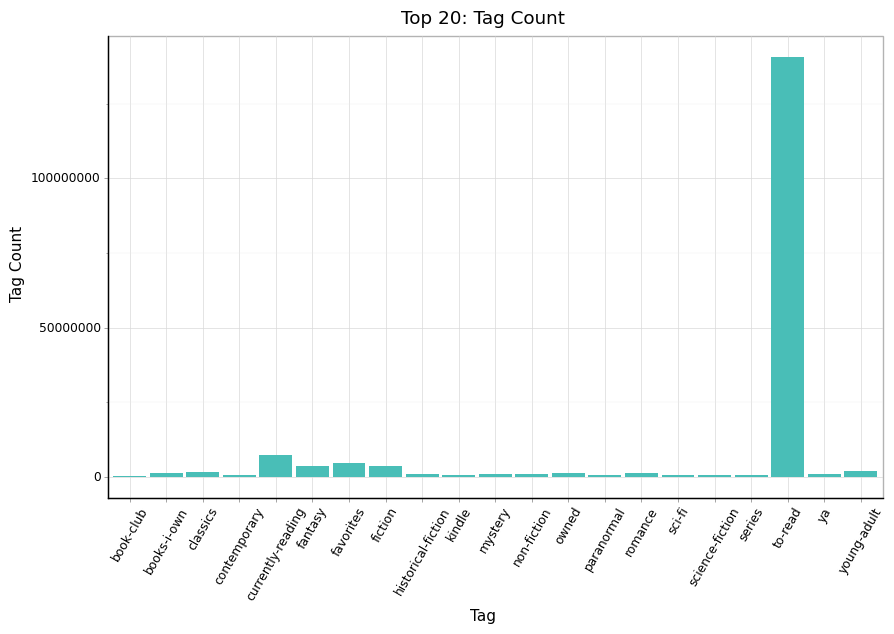

<ggplot: (8794914668673)>

In [ ]:
(ggplot(data = agg.loc[0:20])
  + geom_bar(aes(x='tag_name', y='sum'), fill = '#49beb7', stat = "identity")
  + labs(title = "Top 20: Tag Count",
         x = 'Tag',
         y = 'Tag Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black', rotation=60),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
pd.DataFrame(agg['sum'].describe()).T

,count,mean,std,min,25%,50%,75%,max
sum,34252.0,6097.490716,762709.169868,-1.0,3.0,10.0,52.0,140718761.0


- 태그정보를 통해서 내가 보는 태그의 글을 추천해주는 것도 중요 (성향파악) 
- tag가 유사한 책들로도 추천이 가능

## ratings 평점정보 확인
- 전체 책과 사용자에 대해 기술 통계 

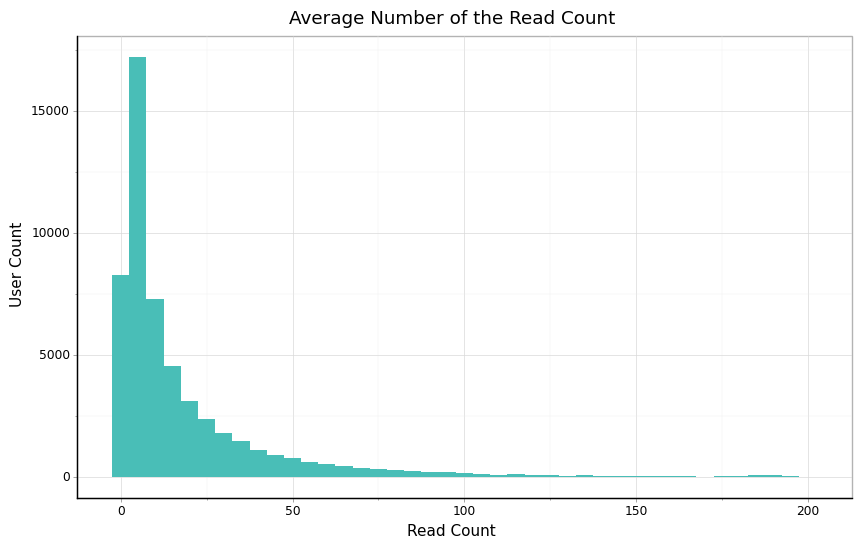

<ggplot: (8794914667297)>

In [ ]:
agg = ratings.groupby(['user_id'])['book_id'].agg({'count'}).reset_index()
(ggplot(data = agg)
  + geom_histogram(aes(x='count'), binwidth = 5, fill = '#49beb7')
  + labs(title = 'Average Number of the Read Count',
         x = 'Read Count',
         y = 'User Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
pd.DataFrame(agg['count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
count,53424.0,18.376685,26.26869,2.0,3.0,8.0,22.0,200.0


- 평균 한 사람이 읽는 책의 수는 18권 
- 최소 2권씩은 구매해서 읽음 
- 최대 많이 읽은 사람은 200권의 책을 구매함 

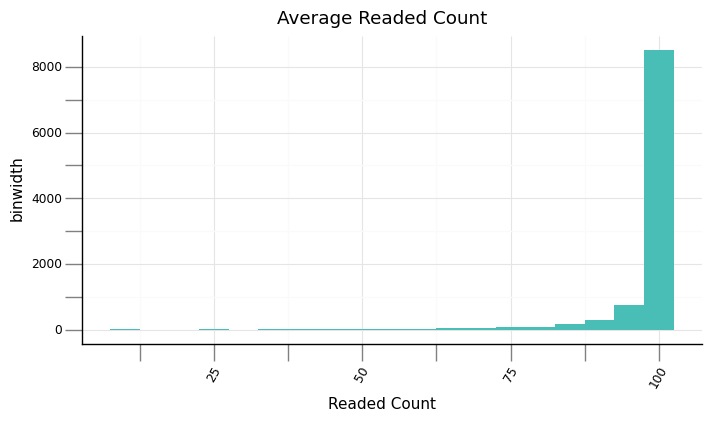

<ggplot: (8794914778105)>

In [ ]:
agg = ratings.groupby(['book_id'])['book_id'].agg({'count'}).reset_index()
(ggplot(data=agg)
    + geom_histogram(aes(x='count', y='stat(count)'), fill = '#49beb7', binwidth=5)
    + theme_minimal()
    + ggtitle("Average Readed Count")
    + labs(x="Readed Count", y="binwidth") 
    + theme(
         axis_text_x = element_text(angle=60, color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(8,4))    
)

In [ ]:
pd.DataFrame(agg['count'].describe()).T

,count,mean,std,min,25%,50%,75%,max
count,10000.0,98.1756,5.690167,8.0,99.0,100.0,100.0,100.0


- 책의 경우 최소 8명은 읽고, 많이 읽힌 책의 경우 100명은 읽었습니다. 
- 편차는 크지만, 평점이 부여된 책들의 대부분이 100명씩은 읽은 책들만 뽑힌 것을 볼 수 있습니다. 
- 이게 책들의 특징이라기보다는 10k만큼의 책을 선정하려고 임의로 샘플링해서 발생한 문제로 보입니다 (ㅜㅜ)

In [ ]:
agg.head()

,book_id,count
0,1,100
1,2,100
2,3,100
3,4,100
4,5,100


In [ ]:
books[books['book_id'].isin([1, 2, 3, 4, 5, 6, 7, 8])].head()

,book_id,authors,title,ratings_count,average_rating,language_code
1,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,4602479,4.44,eng
17,5,"J.K. Rowling, Mary GrandPré, Rufus Beck",Harry Potter and the Prisoner of Azkaban (Harr...,1832823,4.53,eng
20,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix (Har...,1735368,4.46,eng
23,6,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire (Harry Pot...,1753043,4.53,eng
26,1,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...,1678823,4.54,eng


In [ ]:
ratings['user_id'].unique()

array([  314,   439,   588, ..., 43623, 24406, 27590])

In [ ]:
ratings[(ratings['user_id'] == 314) & (ratings['book_id'].isin([1,2,3,4,5,6,7,8]))]

,book_id,user_id,rating
0,1,314,5
200,3,314,3
400,5,314,4
501,6,314,5


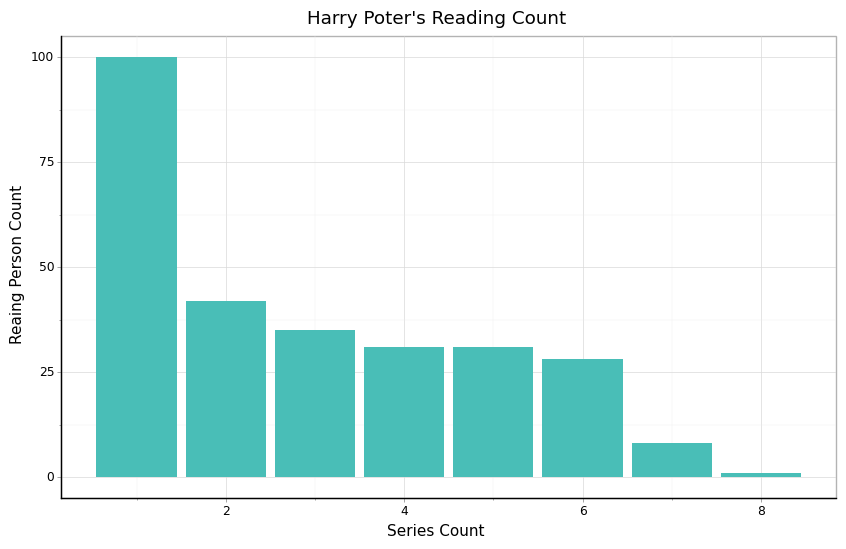

<ggplot: (8794914640193)>

In [ ]:
# ratings를 8개 전부 다 구매한 사람 
agg = ratings[ratings['book_id'].isin([1,2,3,4,5,6,7,8])].groupby(['user_id'])['book_id'].agg({'nunique'})
agg = agg.reset_index()
agg = agg.groupby(['nunique'])['user_id'].agg({'count'}).reset_index()

(ggplot(data = agg)
  + geom_bar(aes(x='nunique', y='count'), fill = '#49beb7', stat = "identity")
  + labs(title = "Harry Poter's Reading Count",
         x = 'Series Count',
         y = 'Reaing Person Count')
  + theme_light() 
    + theme(
         axis_text_x = element_text(color='black'),
         axis_text_y = element_text(color='black'),
         axis_line=element_line(color="black"),
         axis_ticks=element_line(color = "grey"),
         figure_size=(10,6))    
)

In [ ]:
agg['ratio'] = agg['count'] / agg['count'].sum()
agg[['nunique', 'ratio']].T

,0,1,2,3,4,5,6,7
nunique,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000
ratio,0.362319,0.152174,0.126812,0.112319,0.112319,0.101449,0.028986,0.003623


- 해리포터와 같이 시리즈성의 글들은 같이 읽는 경향이 있음 

## to read 정보

In [ ]:
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [ ]:
to_read['user_id'].nunique()

48871

- 이미 읽은 정보뿐만 아니라 읽을 책들에 대한 정보도 결합해서 추천이 가능 

## 학습셋과 검증셋 생성

In [ ]:
agg = ratings.groupby(['user_id'])['book_id'].agg({'unique'}).reset_index()
agg.head()

,user_id,unique
0,1,"[1180, 4893, 6285]"
1,2,"[8034, 8855, 9762]"
2,3,"[9014, 9049]"
3,4,"[3273, 3469, 8464]"
4,5,"[4829, 6646, 6703, 7487, 8072]"


In [ ]:
agg['train'] = agg['unique'].apply(lambda x: np.random.choice(x, len(x)//2))
agg.head()

,user_id,unique,train
0,1,"[1180, 4893, 6285]",[4893]
1,2,"[8034, 8855, 9762]",[8855]
2,3,"[9014, 9049]",[9014]
3,4,"[3273, 3469, 8464]",[3469]
4,5,"[4829, 6646, 6703, 7487, 8072]","[4829, 8072]"


In [ ]:
test = []
for i in tqdm(range(0, agg.shape[0])):
    test_rec = list(set(agg.loc[i, 'unique']).difference(set(agg.loc[i, 'train'])))
    test.append(test_rec)
agg['test'] = test

In [ ]:
# train dataset 
train_map = agg[['user_id', 'train']]

# unnest tags
train_map_unnest = np.dstack(
    (
        np.repeat(train_map.user_id.values, list(map(len, train_map.train))), 
        np.concatenate(train_map.train.values)
    )
)

train_map_unnest = pd.DataFrame(data = train_map_unnest[0], columns = train_map.columns)
train_map_unnest.head()

,user_id,train
0,1,4893
1,2,8855
2,3,9014
3,4,3469
4,5,4829


In [ ]:
# test dataset 
test_map = agg[['user_id', 'test']]

# unnest tags
test_map_unnest = np.dstack(
    (
        np.repeat(test_map.user_id.values, list(map(len, test_map.test))), 
        np.concatenate(test_map.test.values)
    )
)

test_map_unnest = pd.DataFrame(data = test_map_unnest[0], columns = test_map.columns)
test_map_unnest.head()

,user_id,test
0,1,1180
1,1,6285
2,2,8034
3,2,9762
4,3,9049


In [ ]:
train_map_unnest.columns = ['user_id', 'book_id']
test_map_unnest.columns = ['user_id', 'book_id']
train_map_unnest.to_csv("train.csv", index=False)
test_map_unnest.to_csv("test.csv", index=False)

## 정리
- 전체 책을 구매한 사용자는 53424명이고 책의 개수는 10000개 
- 그 중 48871명이 장바구니에 책을 담아두었습니다. 
- 평균적으로 작가당 책이 2권 이상은 됩니다. 